In [19]:
from __future__ import division

from math import sqrt, cos, sin, acos, pi, atan2
from pprint import pprint

from matplotlib import cm
from matplotlib import patches
from matplotlib.colors import LogNorm
from matplotlib.path import Path
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
import numpy as np

#custom module
#from fieldplot import GetFlow3D
#from nanoscale_test import fieldplot2, rotateAroundX, rotateAroundY, rotateAroundZ, angle2D
#from scattnlay import fieldnlay
#from scattnlay import scattnlay

#import nanoscale_test
#import scattnlay

#%run kostin_kod.py

import cma
import sphereml
from scipy.optimize import differential_evolution
from pyfde import JADE
%run algorithms/genetic.py
import time

from joblib import Parallel, delayed
import pyformulas as pf

factor=1.3					# area of plot

In [7]:
def evaluate(ind, layers=2, etype='directivity'):
    assert len(ind)==layers*3+1
    
    r = ind[-1]
    x = ind[:layers]
    m_ = ind[layers:3*layers][::2]
    m_j = ind[layers:3*layers][1::2]
    m = map(lambda t: t[0]+t[1]*1j, zip(m_, m_j))
    
    m = [z for _,z in sorted(zip(x,m), key=lambda pair: pair[0])]
    x = sorted(x)
    
    m = np.array(m)
    x = np.array(x)
    
    px = 1.
    py = 0.
    pz = 0.

    wl = 0.455
    NL = layers
    RL = np.zeros(NL)
    eL = np.zeros(NL+1, dtype=complex)
    eL[:NL] = m[:]
    eL[NL] = 1.
    RL[:] = x[:] / 1000.0
    Rd = r / 1000.0
    
    res = None
    if etype == 'directivity':
        res = sphereml.evaluate_directivity(RL, eL, Rd, wl, px, py, pz, np.pi, 0.)
    elif etype == 'harmonics':
        res = sphereml.evaluate_harmonics(RL, eL, Rd, wl, px, py, pz)
    else: raise ValueError("Unknown etype {}".format(etype))
    return res

def evaluate2(ind, layers=2, etype='directivity', p1=(4., 1e-5 * 2), p2=(6.32455532, 0.)):
    assert len(ind)==layers+2
    mat1, mat1_j = p1
    mat2, mat2_j = p2
    
    t = ind[-1]
    r = ind[-2]
    x = list(ind[:layers])
    
    m1 = [mat1, mat1_j, mat2, mat2_j] * (layers // 2) + [mat1, mat1_j] * (layers % 2)
    m2 = [mat2, mat2_j, mat1, mat1_j] * (layers // 2) + [mat2, mat2_j] * (layers % 2)
    
    if t < .5:
        return evaluate(x + m1 + [r], layers=layers, etype=etype)
    else:
        return evaluate(x + m2 + [r], layers=layers, etype=etype)
    
def run_evaluation2(algo, n_it, r_limits, layers, p1, p2, popsize=None,
                   sigma=0.1, adapt_sigma='True',#cma.sigma_adaptation.CMAAdaptSigmaCSA,
                   sbbx_eta=1.0, log=False,
                   seed=283636):
    def helper(ind):
        helper.calls += 1
        return evaluate2(ind, layers=layers, p1=p1, p2=p2)
    helper.calls = 0
    
    hist = []
    limits = [r_limits]*layers+[(0.1, r_limits[-1]*factor)]+[(0.0, 1.0)]
    
    if popsize is None: popsize = 5*len(limits)
    
    def gen_callback(fitness):
        hist.append((helper.calls, fitness))
        #print("hist: {} {}".format(len(hist), hist[-1]))
        if helper.calls > n_it:
            return True
    
    if algo == 'JADE':
        solver = JADE(helper, n_dim=len(limits), n_pop=popsize, limits=limits)
        for _ in range(int(n_it/popsize)):
            best, fit = solver.run(n_it=1)
            hist.append((helper.calls, fit))
            
    elif algo == 'DE':
        def de_callback(xk, convergence):
            hist.append((helper.calls, evaluate2(xk, layers)))
            if helper.calls > n_it:
                return True
        
        result = differential_evolution(lambda t: -helper(t), limits,
                               callback=de_callback, popsize=popsize, maxiter=n_it)
        best, fit = result.x, -result.fun
    
    elif algo == 'genetic':
        best, fit = genetic(helper,
                            limits=limits, popsize=popsize, generations=1000000, sbbx_eta=sbbx_eta, log=False,
                            callback=gen_callback)
    elif algo == '1+1':
        best, fit = one_plus_one(helper, limits=limits, log=False, callback=gen_callback)
    elif algo == 'CMA':
        initial=get_ind_function(limits)
        #sigma=0.1
        CMA_stds=[1.0 / r_limits[1]]*layers+[1.0/r_limits[-1]/factor]+[1.0]
        bounds=[list(map(lambda t: t[0], limits)), list(map(lambda t: t[1], limits))]
        options={
            'CMA_stds': CMA_stds, 
            'bounds': bounds, 
            #'seed': seed,
            'AdaptSigma': adapt_sigma,
            'verbose': -9
        }
        es = cma.CMAEvolutionStrategy(initial, sigma, options)
        for _ in range(n_it):
            (solutions, func_values) = es.ask_and_eval(lambda t: -helper(t))
            es.tell(solutions, func_values)
            try:
                fit, best = min(zip(func_values, solutions), key=lambda t: t[0])
            except Exception:
                print("{} {}".format(func_values, solutions))
                assert False
            hist.append((helper.calls, -fit))
            if helper.calls > n_it:
                break
    else:
        raise AssertionError("Unknown algo")
    
    if log:
        print("{}: best {} for ind {}".format(algo, fit, best))
    return best, fit, hist

In [8]:
limitsdict = {'r_limits':(10,500)}

def plot_hist(hist, label, linestyle='-'):
    histarr = np.array(hist)
    xs,ys = histarr[:,0],histarr[:,1]
    plt.plot(xs, ys, linestyle=linestyle, label=label)

In [9]:
%%time
n_it=100000
data = []
for layers in [1, 2, 3, 4, 5]:
    for r_limits in [150, 200, 300, 400, 500, 600]:#[30, 40, 45, 60, 75, 90]:
        ind, res, _ =  run_evaluation2('JADE', n_it=n_it, layers=layers, p1=(4., 1e-5 * 2), p2=(sqrt(160.), 0),
                                       r_limits=(10,r_limits))
        print("{} {} result {} for ind {}".format(layers, r_limits, res, ind))
        data.append([layers, r_limits, res, *ind])
print("\n")
pprint(data)
data16_160=data

1 150 result 17.377010247419054 for ind [149.47401227  31.92188781   1.        ]
1 200 result 20.438135161102554 for ind [186.20089018  50.98331389   0.98390458]
1 300 result 15.680941081571293 for ind [256.04720676 185.2978488    0.30335158]
1 400 result 22.859496908220933 for ind [341.35552488 207.46347996   0.42881835]
1 500 result 31.8409510282544 for ind [448.70891379 393.18277592   0.        ]
1 600 result 38.51840258666421 for ind [600.          80.43961854   0.70998939]
2 150 result 16.026100358261086 for ind [149.95737992 149.4849054   51.77319794   0.18390578]
2 200 result 19.01421473553093 for ind [167.58158175 171.25203835  51.32929416   0.74564837]
2 300 result 25.977747632075836 for ind [300.         111.70447154 309.69728882   0.        ]
2 400 result 34.43756615982292 for ind [397.55078048 319.1419823  210.03963867   0.99991066]
2 500 result 42.45612181348992 for ind [335.79663598 499.97467245 489.965766     0.        ]
2 600 result 43.68025032872716 for ind [554.290590

In [11]:
data16_160=[[1,
  30,
  4.42955402893521,
  25.46883297873249,
  38.99999999999998,
  0.9983635709095457],
 [1,
  40,
  7.504701331457766,
  32.929983278454586,
  18.27032458461976,
  0.9988878427526096],
 [1,
  45,
  8.834645428834204,
  39.95846581698101,
  24.825947772463827,
  0.5166571103612355],
 [1,
  60,
  10.718602226602274,
  59.6105518822804,
  62.84957560306705,
  0.5047515015267834],
 [1,
  75,
  8.126753608731892,
  70.4576931614968,
  59.498366202459486,
  0.6154234000334544],
 [1,
  90,
  10.718602226602274,
  59.610551882534395,
  62.84957551518749,
  0.6941081511817755],
 [2,
  30,
  4.429554028935252,
  25.468832979106416,
  25.468832979106633,
  38.99999999999963,
  0.5150463214857117],
 [2,
  40,
  7.472860482981432,
  32.96001915023319,
  33.32369795617718,
  33.323697956177085,
  0.608394385630084],
 [2,
  45,
  7.4728604829814325,
  33.323698645545804,
  32.960019077742416,
  33.32369864554575,
  0.09639765737882446],
 [2,
  60,
  10.719701601187,
  59.60136952030094,
  59.695543661130294,
  62.96633800500611,
  1.0],
 [2,
  75,
  10.71970160118701,
  59.60136952834415,
  59.69554358450602,
  62.96633793420746,
  0.9946481650323931],
 [2,
  90,
  10.293819117392799,
  43.384218467474675,
  73.31076254527568,
  85.80585969125671,
  0.04350323472648365],
 [3,
  30,
  4.42955402893526,
  25.468832979609513,
  25.468832979609655,
  17.413670053879112,
  39.0,
  1.0],
 [3,
  40,
  7.472860482981433,
  32.9600191079823,
  33.323698365070065,
  13.713504927681281,
  33.32369836507002,
  0.541656068458442],
 [3,
  45,
  7.504741332424506,
  10.0,
  32.98538908431627,
  32.924159330205505,
  18.263311511071983,
  0.5777657518362183],
 [3,
  60,
  10.719701601187023,
  22.205529807587567,
  59.69554366485426,
  59.60136951854795,
  62.966338006490766,
  0.5330373627682412],
 [3,
  75,
  12.233526477936065,
  74.98845366668999,
  52.144446898987496,
  45.1988097970061,
  46.8135539764449,
  0.6158243672892806],
 [3,
  90,
  8.055896761952479,
  89.26105542939457,
  18.400702517640877,
  19.2488852417207,
  117.0,
  0.7094572819000775],
 [4,
  30,
  4.376190942797897,
  25.326966461205508,
  25.420363510270217,
  25.430329176752505,
  25.664745918369753,
  33.061123575591324,
  0.6925857650789821],
 [4,
  40,
  9.088739638920588,
  33.45969613349583,
  33.476192568163675,
  40.0,
  33.475414327649126,
  40.001309196703524,
  0.8246419478905819],
 [4,
  45,
  8.437725800487163,
  44.618197281409415,
  12.22273360957201,
  27.59279008145262,
  34.68599755323638,
  28.21062414009236,
  0.6724110717627474],
 [4,
  60,
  10.707158292978724,
  59.57075131524035,
  59.98560794017423,
  15.1035134748167,
  59.60525400245648,
  63.36769185446325,
  0.5638583989801158],
 [4,
  75,
  11.893593210209888,
  40.69578876405759,
  46.05895288620668,
  71.72974622005057,
  64.84267127642853,
  75.26628376260565,
  0.08578037566534107],
 [4,
  90,
  12.523068669434924,
  79.80679543599327,
  18.84636017259459,
  90.0,
  83.42015697656342,
  106.42267468836012,
  1.0],
 [5,
  30,
  4.400690705270014,
  24.247242599837126,
  22.670931054022752,
  25.672318018998222,
  22.63993909470045,
  22.428931077834786,
  35.987492776970726,
  0.9192065614179641],
 [5,
  40,
  8.447694853593815,
  10.082560013734403,
  14.641450209822013,
  39.98867182991176,
  17.096651256867272,
  39.73527138784936,
  30.209951035581632,
  0.7852001480617415],
 [5,
  45,
  9.81534600827621,
  39.73782640773271,
  40.717909239593254,
  36.50017345029508,
  43.2057113456396,
  18.967160383181465,
  44.43003361680989,
  0.5799057224475934],
 [5,
  60,
  10.573138420063616,
  10.041478237707523,
  10.296716701427032,
  21.05160616856966,
  10.287282101851446,
  59.59761250714856,
  42.63221209324103,
  0.7319367271057665],
 [5,
  75,
  10.788987604515146,
  74.99825036636778,
  73.08568883874524,
  65.68233064585223,
  62.377385699245316,
  21.872178690247555,
  81.22069365692177,
  0.26093131468248665],
 [5,
  90,
  12.946730585394741,
  39.182329140585786,
  20.616357892550955,
  90.0,
  42.68057636015475,
  14.071561882267316,
  99.2009058845478,
  0.840650028844844],
 [1, 150, 17.377010247419054, 149.4740122698237, 31.921887805473755, 1.0],
 [1,
  200,
  20.438135161102554,
  186.20089017604832,
  50.983313892196485,
  0.9839045807594823],
 [1,
  300,
  15.680941081571293,
  256.047206761186,
  185.29784879598571,
  0.30335158017563524],
 [1,
  400,
  22.859496908220933,
  341.3555248766408,
  207.46347996249162,
  0.42881834915455536],
 [1, 500, 31.8409510282544, 448.70891379190755, 393.182775924582, 0.0],
 [1, 600, 38.51840258666421, 600.0, 80.43961853645204, 0.7099893936125516],
 [2,
  150,
  16.026100358261086,
  149.95737992468864,
  149.48490539610046,
  51.77319794067763,
  0.1839057801692736],
 [2,
  200,
  19.01421473553093,
  167.5815817460054,
  171.2520383493778,
  51.32929415521973,
  0.7456483675949551],
 [2,
  300,
  25.977747632075836,
  300.0,
  111.70447154345065,
  309.6972888166978,
  0.0],
 [2,
  400,
  34.43756615982292,
  397.55078048192826,
  319.1419822963172,
  210.03963866851672,
  0.9999106578203748],
 [2,
  500,
  42.45612181348992,
  335.79663598405875,
  499.97467245163944,
  489.9657659998441,
  0.0],
 [2,
  600,
  43.68025032872716,
  554.290590646382,
  483.44488630742126,
  563.9504514117168,
  0.8695715112102663],
 [3,
  150,
  12.63612073916466,
  10.0,
  141.53866571572217,
  10.0,
  45.510529496948365,
  0.0],
 [3,
  200,
  21.843752961183327,
  191.11735317795478,
  155.31570569290255,
  102.25397789392508,
  144.8014597334323,
  0.3282487780290811],
 [3,
  300,
  26.26669705623432,
  232.66549195660497,
  266.0652435209955,
  300.0,
  184.07640720554824,
  0.37431019285663913],
 [3,
  400,
  38.923686249226996,
  395.7095564500017,
  275.9677360766873,
  296.557630306552,
  64.54590217779467,
  0.3517421486685665],
 [3,
  500,
  48.66611556162073,
  432.40317182046226,
  454.65961091258424,
  499.5929508298416,
  257.87446753817443,
  0.43767540951170825],
 [3,
  600,
  43.431438070964774,
  580.7843808835268,
  600.0,
  372.5718224972556,
  354.92943031376984,
  0.4290338670392981],
 [4,
  150,
  20.488642097526977,
  150.0,
  93.68789402705231,
  51.08704761267335,
  51.24240131504292,
  109.05825452149934,
  0.7778159881486169],
 [4,
  200,
  19.74445144101083,
  182.79124153348576,
  56.669423612080294,
  86.2710708195143,
  99.12830435716118,
  183.792177550788,
  0.8338258325385706],
 [4,
  300,
  32.47088500061755,
  152.43742280598286,
  300.0,
  239.68576927774774,
  24.467443342272226,
  124.04202910212248,
  0.5977418430482787],
 [4,
  400,
  40.88455647056065,
  278.16557000732536,
  365.09328918236434,
  399.01718208324337,
  10.340418041537532,
  229.61584537554776,
  0.0],
 [4,
  500,
  41.713361859671046,
  471.9722357992109,
  135.885280782916,
  220.03387484400685,
  299.1850587300951,
  287.59816811515606,
  0.0],
 [4,
  600,
  56.358996210949954,
  487.52655417511187,
  498.3406534417224,
  547.401605342885,
  600.0,
  323.9779412172947,
  0.15738623797991008],
 [5,
  150,
  18.59131557187595,
  60.84095598722676,
  93.7046445689489,
  20.509911979736557,
  36.33290993791834,
  150.0,
  138.2300808435777,
  0.7857997231445566],
 [5,
  200,
  22.353060348044867,
  63.631704705749804,
  50.83787617530379,
  31.797797809865603,
  69.62412099945385,
  192.94973648395805,
  173.5285686261322,
  0.6116080324333241],
 [5,
  300,
  35.36601450610695,
  290.14723694853205,
  270.93397784565377,
  253.52965610482812,
  10.0,
  291.918299485248,
  113.56867305046401,
  0.8634021071543908],
 [5,
  400,
  36.484347134434955,
  205.18359010970858,
  323.17152340831444,
  131.2947464455708,
  174.41211254948502,
  392.9760177082046,
  359.8607372140957,
  1.0],
 [5,
  500,
  53.0086341342922,
  497.89815827024637,
  164.5657241375336,
  145.56107455557228,
  237.86136385204662,
  407.09551724510965,
  483.5637012340109,
  0.9651233592321353],
 [5,
  600,
  60.1056617814841,
  10.0,
  588.2951704912683,
  10.0,
  487.8171326915283,
  549.0755417209965,
  259.4221352572114,
  0.739683045160198]]
data16_160 = [[t[0], t[1], t[2], t[3:]] for t in data16_160]
data16_160 = np.array(data16_160)

In [10]:
%%time
n_it=100000
data = []
for layers in [1, 2, 3, 4, 5]:
    for r_limits in [150, 200, 300, 400, 500, 600]:
        ind, res, _ =  run_evaluation2('JADE', n_it=n_it, layers=layers, p1=(sqrt(40.), 0), p2=(sqrt(160.), 0),
                                       r_limits=(10,r_limits))
        print("{} {} result {} for ind {}".format(layers, r_limits, res, ind))
        data.append([layers, r_limits, res, *ind])
print("\n")
pprint(data)
data40_160=data

1 150 result 10.826116252893426 for ind [1.48155141e+02 1.01550096e+02 3.27720661e-06]
1 200 result 15.193077851256847 for ind [1.86987228e+02 1.03638621e+02 8.69275930e-02]
1 300 result 23.574824036981248 for ind [276.99481283  73.89355562   0.4889818 ]
1 400 result 27.624426233816276 for ind [3.67570378e+02 1.29951913e+02 3.52571813e-01]
1 500 result 31.574639966166327 for ind [4.93894403e+02 1.46224421e+02 2.07804143e-02]
1 600 result 38.51840258666424 for ind [600.          80.43961848   0.64908066]
2 150 result 11.775222972448805 for ind [147.15337285  91.39307974 133.04597384   0.91677476]
2 200 result 19.807589686596174 for ind [2.00000000e+02 1.72082373e+02 1.05607093e+02 6.43605993e-02]
2 300 result 23.510115812937094 for ind [273.96241946 272.82945243 117.01532652   0.98660155]
2 400 result 29.82226209348236 for ind [2.12934598e+02 3.59401421e+02 1.31519899e+02 3.00929277e-01]
2 500 result 35.47992192469573 for ind [2.81094173e+02 5.00000000e+02 1.60209827e+02 1.17626682e-01]

In [12]:
data40_160=[[1,
  30,
  3.9999481435142727,
  25.724945917512887,
  25.66078410006628,
  0.9655200809054925],
 [1,
  40,
  3.999948143514274,
  25.72494591053813,
  25.66078516304142,
  0.6082533456165564],
 [1,
  45,
  8.834645428834184,
  39.95846581565119,
  24.825947921757816,
  0.7117874527275037],
 [1,
  60,
  5.200502341201275,
  49.09130492909651,
  74.00054219713624,
  0.3395260041545456],
 [1,
  75,
  10.718602226602274,
  59.61055188251797,
  62.84957560383463,
  0.9428927995559371],
 [1,
  90,
  9.21282124896949,
  79.80814378109504,
  88.9751306385696,
  0.08745809462512522],
 [2,
  30,
  4.429554028935343,
  25.468832979418274,
  25.468832979417705,
  38.99999999999999,
  0.2147979442160209],
 [2,
  40,
  7.473963094333469,
  33.25172441290608,
  32.912607709505274,
  33.251724412906086,
  0.025855153361789895],
 [2,
  45,
  7.473963094333471,
  33.251724444701985,
  32.91260769874069,
  33.251724444701985,
  0.014156425451078114],
 [2,
  60,
  7.048847942428471,
  60.0,
  13.527139100033432,
  45.708828668372824,
  0.7403406555783195],
 [2,
  75,
  10.719113875925538,
  59.64833656794311,
  59.59829625751177,
  62.908278421872886,
  0.39943005554682587],
 [2,
  90,
  9.217726343494608,
  86.8428362712594,
  85.81392012648222,
  44.48074052578852,
  0.4207442177405396],
 [3,
  30,
  4.429554028935348,
  25.468832978163377,
  25.468832978163793,
  24.150055000036826,
  39.0,
  0.5918367227292836],
 [3,
  40,
  8.834645428834314,
  39.958465816315105,
  39.958465816315176,
  30.97106252388839,
  24.82594789942136,
  0.526822154949857],
 [3,
  45,
  7.8464909217522,
  42.64865073731044,
  32.988853952024456,
  29.465431956847823,
  43.5723143900617,
  0.5203046462362044],
 [3,
  60,
  10.719203332679397,
  59.59590624104262,
  59.65502006581504,
  18.761942454704194,
  62.91324037747011,
  0.6888898038289278],
 [3,
  75,
  13.423564325411608,
  75.0,
  55.50185698662595,
  18.985203178944808,
  79.22275753743175,
  0.8612576739684809],
 [3,
  90,
  11.625216805086051,
  48.994810105184214,
  83.64598993562771,
  42.1989081797742,
  79.22001365835087,
  0.9538267785284615],
 [4,
  30,
  4.4542767300578365,
  29.00145801158039,
  26.214641683502034,
  19.09843224924707,
  16.90006179747656,
  39.0,
  0.46526218496531657],
 [4,
  40,
  7.932871327959895,
  39.97311718927574,
  39.98452291588182,
  17.26995974988218,
  40.0,
  40.113893263661424,
  0.8602764198375535],
 [4,
  45,
  8.85632154668931,
  45.0,
  38.973179534504524,
  42.227720451439275,
  45.0,
  47.220184837087274,
  0.3900198942666012],
 [4,
  60,
  11.04334544651801,
  10.0,
  10.411615427693327,
  59.4881597110703,
  60.0,
  62.44239349959412,
  1.0],
 [4,
  75,
  11.344423810576057,
  11.180920653491107,
  21.107151338154985,
  62.4348709378383,
  58.865842601468756,
  63.63793623843512,
  0.3891111359130201],
 [4,
  90,
  10.71465643834403,
  32.87020407279899,
  10.882721786116196,
  75.56391485026751,
  52.18701564118073,
  50.432510948242985,
  0.620043182845764],
 [5,
  30,
  4.427362151272859,
  29.644144028410153,
  19.9780111684901,
  16.609869814778385,
  24.627015925629177,
  20.402774979462407,
  35.47360421799816,
  0.8462070161753805],
 [5,
  40,
  9.141947706856094,
  10.0,
  10.103457034878874,
  39.97676685316777,
  11.847427929740352,
  11.69845978803721,
  39.98390104585688,
  0.8438960305485097],
 [5,
  45,
  8.786120815341183,
  36.11842523804502,
  45.0,
  45.0,
  10.0,
  38.978516611557225,
  45.983614898894444,
  0.6990903653115946],
 [5,
  60,
  12.659451881318974,
  59.165323136855385,
  51.01399776074606,
  60.0,
  17.730077425085565,
  47.08758187216241,
  48.87946816544074,
  0.8668629996306938],
 [5,
  75,
  13.147164474192195,
  12.56957325349076,
  41.560601572664666,
  71.47634415586447,
  22.802819750442524,
  35.13082426428042,
  52.9734373924833,
  0.4341216354004539],
 [5,
  90,
  15.57883764689599,
  82.27904843161802,
  82.0566201802514,
  41.2069949016838,
  23.288273145764222,
  38.4493353772309,
  84.4459684927363,
  0.42620651165145007],
 [1,
  150,
  10.826116252893426,
  148.1551408328931,
  101.55009553825542,
  3.2772066103507332e-06],
 [1,
  200,
  15.193077851256847,
  186.98722785172853,
  103.63862062155508,
  0.08692759304310202],
 [1,
  300,
  23.574824036981248,
  276.9948128345765,
  73.89355561542658,
  0.4889818001932347],
 [1,
  400,
  27.624426233816276,
  367.5703783880385,
  129.95191282632226,
  0.3525718128213147],
 [1,
  500,
  31.574639966166327,
  493.89440320739385,
  146.2244214357798,
  0.020780414315881488],
 [1, 600, 38.51840258666424, 600.0, 80.43961847613042, 0.6490806582318835],
 [2,
  150,
  11.775222972448805,
  147.1533728527513,
  91.3930797385019,
  133.04597384125998,
  0.9167747585852045],
 [2,
  200,
  19.807589686596174,
  200.0,
  172.08237257428775,
  105.6070927878063,
  0.0643605993440389],
 [2,
  300,
  23.510115812937094,
  273.96241945691685,
  272.8294524274428,
  117.01532651642762,
  0.9866015488825888],
 [2,
  400,
  29.82226209348236,
  212.934597636591,
  359.4014214066081,
  131.5198992945668,
  0.30092927701110095],
 [2,
  500,
  35.47992192469573,
  281.0941733937369,
  500.0,
  160.20982673535545,
  0.11762668217301428],
 [2, 600, 43.96430769642695, 600.0, 216.8562650177082, 178.36204733948335, 1.0],
 [3,
  150,
  18.178575925022212,
  36.5757020784585,
  29.927398885797544,
  148.08042520301765,
  59.50146592464729,
  0.2674710040512892],
 [3,
  200,
  20.460675257214213,
  197.52501399121124,
  76.21148137550142,
  14.525315344679914,
  49.67967288909456,
  0.20105459552569555],
 [3,
  300,
  33.226740289350545,
  300.0,
  235.50924698497226,
  228.4646293213708,
  117.4103806716758,
  0.0],
 [3,
  400,
  38.86127928468678,
  220.9776211946158,
  337.38742764916583,
  399.9869709872202,
  105.65956304925126,
  0.4837662140693114],
 [3,
  500,
  35.61361080095041,
  229.49555611680842,
  499.50759316878475,
  280.4565531000045,
  160.3700931942611,
  0.0071984969236153495],
 [3,
  600,
  48.24615161789307,
  590.1532939162807,
  534.3074887233441,
  558.6622012256205,
  132.71016169063037,
  1.0],
 [4,
  150,
  19.3799293710546,
  50.64765931523945,
  29.023539474870468,
  147.90064804408524,
  52.74152002190079,
  58.02750379141043,
  0.1103782192866857],
 [4,
  200,
  21.87125249826948,
  172.13409547705095,
  12.236701617037154,
  127.47995057250878,
  200.0,
  87.0148262118466,
  1.0],
 [4,
  300,
  34.457632633758394,
  300.0,
  129.6861807878343,
  18.904827483463805,
  149.13380263797427,
  102.39545846435531,
  0.49568636223639145],
 [4,
  400,
  39.93461248126438,
  371.3895454042522,
  302.0224847239072,
  233.1017796577593,
  200.87658011982606,
  132.26965101067506,
  0.6595189479356048],
 [4,
  500,
  44.23549298685817,
  359.52574122085554,
  222.42753142340828,
  499.9990383271594,
  475.1346899450786,
  153.86173849830976,
  0.8943459587233853],
 [4,
  600,
  53.15364105227269,
  579.3856420753848,
  434.1515570595746,
  375.1097806827585,
  344.47533412250925,
  164.16138863429734,
  0.8476373024685785],
 [5,
  150,
  18.194446535367433,
  122.11627837334439,
  34.72018082340696,
  31.399200840182626,
  148.3319196684812,
  109.1642704011939,
  74.88748918154998,
  0.6388822973497847],
 [5,
  200,
  26.691966345944163,
  173.2371959571262,
  136.9122318176108,
  116.90786725288314,
  161.76763718914646,
  87.78684448688256,
  69.56603551619804,
  0.9682116310745161],
 [5,
  300,
  30.26233774246667,
  299.97315594430853,
  237.95580356295451,
  259.79524565590685,
  212.8223894224711,
  211.189968241727,
  115.23860391294029,
  0.4154554013457915],
 [5,
  400,
  37.87179994360156,
  209.69125140825207,
  379.5009249440568,
  282.9728282620465,
  252.98948498120745,
  338.1556791278795,
  131.35198696781535,
  0.2451152758156175],
 [5,
  500,
  41.89682300770855,
  391.6845557121738,
  371.00822456448293,
  337.97103541037694,
  321.6739013022249,
  464.6015871411306,
  166.71285034778802,
  0.2167955349414019],
 [5,
  600,
  50.64465417683573,
  235.8012662697564,
  386.294549811602,
  600.0,
  545.6154141388716,
  440.5894561702371,
  163.01870607507215,
  0.32220370014434657]]

data40_160 = [[t[0], t[1], t[2], t[3:]] for t in data40_160]
data40_160 = np.array(data40_160)

In [13]:
data16_40=np.array([
    [1, 30, 1.775751725477784, [30.,         34.67768707,  0.62187264]],
    [1, 40, 2.999431067110813, [35.2864797,   0.42953387,  0.98649055]],
    [1, 45, 2.088379423756302, [34.65968656, 58.5,         0.83456329]],
    [1, 60, 5.200502341216903, [49.09130493, 74.00054221,  0.94013005]],
    [1, 75, 7.213574556245152, [65.9705437,  65.9705437,   0.76288184]],
    [1, 90, 9.212821248878406, [79.80814379, 88.97513055,  0.70259159]],
    [2, 30, 1.7757517254777837, [30.,         30.,         34.67768703,  0.58159864]],
    [2, 40, 2.024178767901479, [34.40728386, 34.40728386, 52.,          0.48226755]],
    [2, 45, 2.9288375976383123, [45.,         10.,         47.10301669,  1.        ]],
    [2, 60, 5.1111660247451844, [5.77042467e+01, 3.50066686e+01, 7.80000000e+01, 7.59068350e-02]],
    [2, 75, 7.912632826011905, [64.7598327,  65.61105955, 43.4327922,   0.98894252]],
    [2, 90, 9.226084647788646, [79.5669062,  80.1969981,  89.51244011,  0.77512593]],
    [3, 30, 1.775751725477784, [10.,         10.,         30.,         34.67768751,  0.74255312]],
    [3, 40, 2.024007990377647, [10.,         34.47399937, 10.,         52.,          0.        ]],
    [3, 45, 3.1626392234709244, [10.,         10.,         45.,         48.15877233,  0.91448812]],
    [3, 60, 5.200502341216901, [49.09130492, 49.09130492, 32.76059667, 74.00054221,  0.62758385]],
    [3, 75, 7.912632826011915, [64.75983279, 65.61105941, 39.41617425, 43.43279227,  0.96464656]],
    [3, 90, 10.423289531750699, [35.32134968, 22.34620548, 79.57992073, 54.4153481,   0.89773448]],
    [4, 30, 1.7690788470794876, [10.,         24.77645962, 10.,         30.,         34.65496164,  0.27133245]],
    [4, 40, 2.9994579739627407, [16.09441082, 13.51212911, 13.86291886, 35.60564901,  0.39949139,  0.        ]],
    [4, 45, 2.9983518464550687, [32.42139137, 20.29268967, 41.6502771,  40.21323364,  0.85700384,  0.46959087]],
    [4, 60, 5.225064102808191, [28.75661283, 39.34590842, 53.02105104, 36.83790863, 77.71103781,  0.67833928]],
    [4, 75, 8.117220087159595, [24.51678984, 74.22439744, 61.51685351, 27.55394645, 43.47797785,  0.51009389]],
    [4, 90, 10.746968251674359, [32.25128292, 65.41590527, 73.78859627, 86.52582715, 56.87007049,  0.16636171]],
    [5, 30, 1.7757517254777835, [10.,         10.,         30.,         10.,         30.,         34.67768708, 0.82664928]],
    [5, 40, 2.02417876790148, [34.40728387, 10.,         10.,         10.,         20.79061801, 52., 1.        ]],
    [5, 45, 2.998442451182066, [20.36425515, 32.99203844, 19.11548605, 24.13752394, 41.05767147,  0.84380149, 0.51494046]],
    [5, 60, 5.2121346380487354, [49.16855043, 33.53847354, 50.51468525, 52.46321614, 28.18609916, 75.92356462, 0.71080168]],
    [5, 75, 8.093567823830139, [45.3642455,  75.,         61.11069628, 25.65569507, 20.17778244, 45.50527732, 0.80343704]],
    [5, 90, 9.759999880655982, [79.63927732, 11.43717342, 22.55768149, 25.64090644, 74.82125846, 56.30492877, 0.50310435]],
    [1, 150, 10.019995681001953, [133.73680382,  93.53019695,   0.57516669]],
    [1, 200, 16.86736315439149, [186.71322771,  61.1759746,    0.66823203]],
    [1, 300, 16.581031597512737, [2.55634446e+02, 1.17265367e+02, 4.16986921e-02]],
    [1, 400, 25.3070820985615, [3.63915160e+02, 3.09002425e+02, 7.78984680e-02]],
    [1, 500, 32.198230402297625, [4.48786159e+02, 4.48786159e+02, 2.07962804e-01]],
    [1, 600, 33.72576999612941, [561.56514057, 116.7612912,    0.99993964]],
    [2, 150, 15.451089370534753, [1.08677653e+02, 1.50000000e+02, 9.81252959e+01, 2.48481487e-02]],
    [2, 200, 17.1392104229388, [119.29574573, 180.96076475, 198.82042695,   0.73130784]],
    [2, 300, 21.53431147564111, [300.,         166.77033749, 215.09236795,   0.54837443]],
    [2, 400, 27.60976653605185, [3.88631375e+02, 3.33061038e+02, 1.29749733e+02, 2.18619683e-01]],
    [2, 500, 44.109474789932584, [2.51581930e+02, 4.98457122e+02, 5.08365847e+02, 2.81563855e-01]],
    [2, 600, 52.09573204044275, [4.82445674e+02, 5.97912478e+02, 5.73429163e+02, 3.78977573e-01]],
    [3, 150, 13.346798891722878, [142.7550668,  107.74375373, 143.55558972, 143.49396507,   0.58873515]],
    [3, 200, 20.033428681952504, [ 89.6230923,  105.27246453, 198.88389166, 208.06115361,   0.94100714]],
    [3, 300, 29.042037766581334, [297.19750756, 166.80052028, 157.20504568, 132.29165707,   0.95641366]],
    [3, 400, 39.83731618192996, [3.20410818e+02, 3.55723530e+02, 3.99991318e+02, 3.07492487e+02, 1.24024123e-01]],
    [3, 500, 37.5069438243178, [3.51376431e+02, 4.97720029e+02, 2.13159447e+01, 4.74185882e+02, 6.44989325e-02]],
    [3, 600, 49.10320813354117, [3.57863844e+02, 5.99925105e+02, 4.85575056e+02, 5.74516229e+02, 3.42349490e-01]],
    [4, 150, 16.183783333316924, [106.63631108, 150.,         139.44251116, 137.75427056, 100.74805213,   0.44426961]],
    [4, 200, 21.245495680659502, [200.,         131.74178038,  36.41733799,  24.74735587, 112.13373959,   0.39779347]],
    [4, 300, 28.5625132302796, [194.03038591, 185.37762072, 300.,         250.36450657, 185.50648896,   0.40961414]],
    [4, 400, 32.172403858144214, [372.35642503, 355.89915151, 396.01477509, 374.28589233, 235.1571667,   0.58941035]],
    [4, 500, 44.94085795980351, [497.85867247, 499.86468796,  66.91584725, 251.79184538, 503.72836487,   0.64061464]],
    [4, 600, 51.4128946145551, [570.21303813, 567.86373373, 600.,         573.02726536, 610.4859203,   0.93123554]],
    [5, 150, 17.234671153813096, [1.49930776e+02, 5.63080816e+01, 1.18506713e+02, 1.02948717e+02, 8.24762814e+01, 8.26503675e+01, 1.35301235e-01]],
    [5, 200, 20.3767578603061, [132.10502765, 200.,          21.83856993,  38.36783066, 200., 166.416978,     0.92823647]],
    [5, 300, 34.00166351919821, [211.76196612, 237.73202407, 257.1690824,   24.9790432,  283.63149981, 118.66687883,   0.78431   ]],
    [5, 400, 36.88431013218268, [254.37578884,  33.62959047, 387.76601456, 308.41461815,  41.77880769, 208.5397996,    0.92091935]],
    [5, 500, 42.11733922423533, [500.,         245.12866328, 272.6952554,  365.4017171,  403.84033579, 496.08436685,   0.61356102]],
    [5, 600, 63.87348767442431, [600.,         367.16129826, 342.85230862, 564.41652274, 471.76974354, 554.70007772,   0.]]
])
#harmonics=[evaluate2(it[3], layers=it[0], etype='harmonics') for it in data16_40]

In [25]:
wave_type = 'e'
harm = harmonics[0]
N=41
start_from = 0 if wave_type == 'e' else N**2
for i in range(N):
    amplitudes = [start_from+i*(i+1)+j for j in range(-i,i+1)]
    plt.scatter()numpy.random.rand(3,1)
print(cnt)

100


In [4]:
print(evaluate2([21.8482052, 16.54311129, 35.05937398, 52., 0.57570108], layers=3))
print(evaluate2([21.8482052, 16.54311129, 35.05937398, 52., 0.57570108], layers=3, etype='harmonics'))

2.0153067985479622
[ 0.       +0.j         -0.2525206-0.10447908j  0.       +0.j         ...
  0.       +0.j          0.       +0.j          0.       +0.j        ]


[(0.01308853549143436, 0.009330472805243923),
 (0.001747202522417173, 0.018266757186177665),
 (0.0, 0.0),
 (0.021072745590514735, 0.003128666050293947),
 (0.0, 0.0),
 (0.000674695643017088, 0.0008340567567383081),
 (0.0, 0.0),
 (4.877075172031808e-05, 0.0009471829173146427),
 (0.0, 0.0),
 (0.0, 0.0),
 (1.0154793705150623e-06, 1.367170373680496e-05),
 (0.0, 0.0),
 (0.0, 0.0),
 (0.0, 0.0),
 (0.030060222348161667, 1.6261623215990825e-06),
 (0.0, 0.0),
 (0.0, 0.0),
 (0.0, 0.0),
 (6.818785931842162e-08, 1.5359853488510277e-07),
 (0.0, 0.0)]


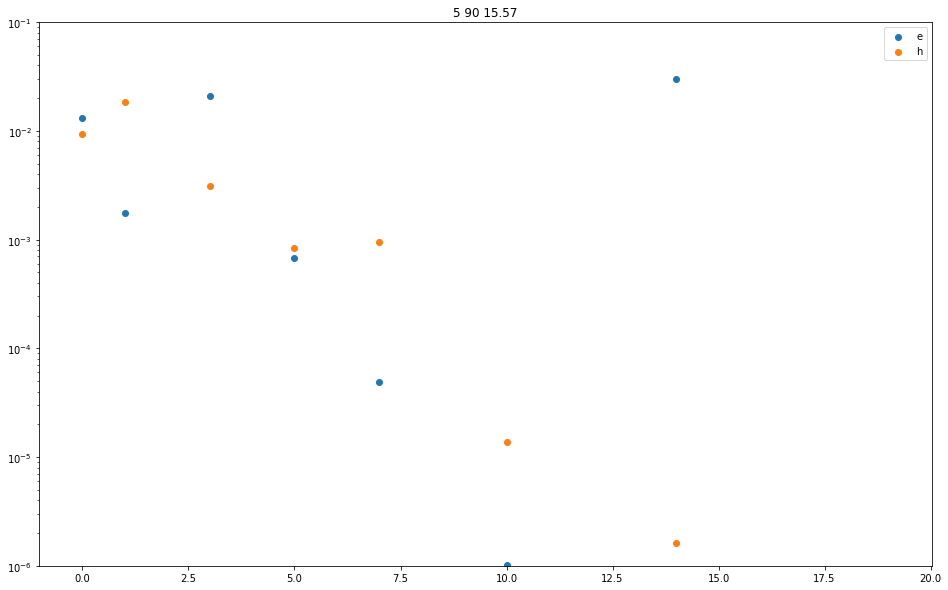

In [74]:
t=evaluate2([82.27904843161802,
  82.0566201802514,
  41.2069949016838,
  23.288273145764222,
  38.4493353772309,
  84.4459684927363,
  0.42620651165145007], layers=5, 
            p1=(sqrt(40.), 0), p2=(sqrt(160.), 0), etype='harmonics')

e = [np.abs(it) for it in t[1:80:4]]
h = [np.abs(it) for it in t[1682:1761:4]]

pprint(list(zip(e, h)))

plt.figure(figsize=(16, 10))
plt.scatter(range(len(e)), e, label='e')
plt.scatter(range(len(h)), h, label='h')
plt.legend()
plt.title("5 90 15.57")
plt.yscale('log')
plt.ylim(1e-6, 1e-1);

[(0.0017373038852364284, 0.002643113041866491),
 (0.00290550619984745, 0.00249059033531907),
 (0.0, 0.0),
 (0.0011378931498782928, 0.0032962437577060784),
 (0.0, 0.0),
 (0.004434453552380052, 0.00023761558749493342),
 (0.0, 0.0),
 (2.295090885728489e-05, 0.00016864844017772213),
 (0.0, 0.0),
 (0.0, 0.0),
 (0.003303922781780756, 4.237180645446699e-06),
 (0.0, 0.0),
 (0.0, 0.0),
 (0.0, 0.0),
 (5.332498247887194e-06, 8.206273500436021e-07),
 (0.0, 0.0),
 (0.0, 0.0),
 (0.0, 0.0),
 (1.6552316237511108e-06, 2.8317622240685415e-07),
 (0.0, 0.0)]


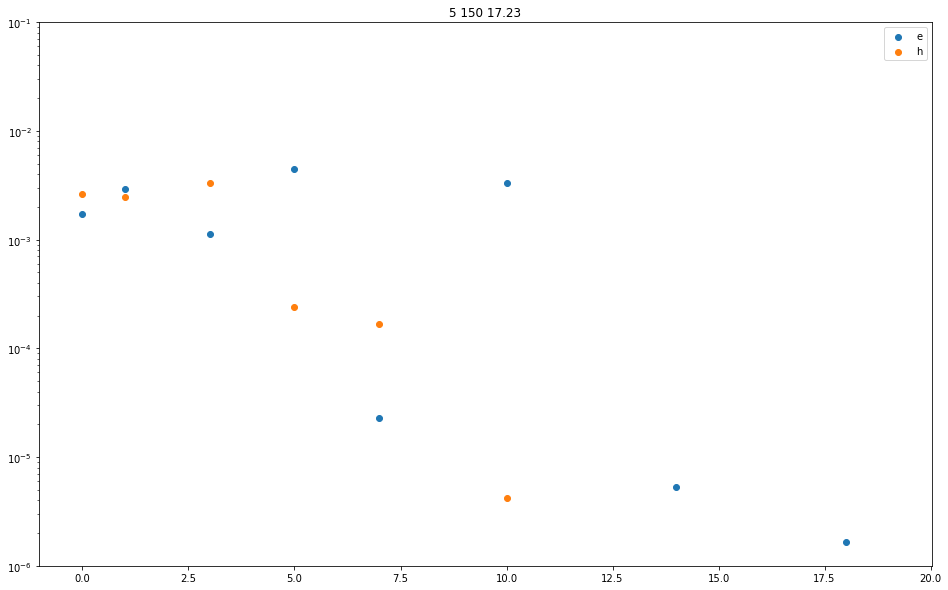

In [75]:
t=evaluate2([122.11627837334439,
  34.72018082340696,
  31.399200840182626,
  148.3319196684812,
  109.1642704011939,
  74.88748918154998,
  0.6388822973497847], layers=5, 
            p1=(sqrt(40.), 0), p2=(sqrt(160.), 0), etype='harmonics')

e = [np.abs(it) for it in t[1:80:4]]
h = [np.abs(it) for it in t[1682:1761:4]]

pprint(list(zip(e, h)))

plt.figure(figsize=(16, 10))
plt.scatter(range(len(e)), e, label='e')
plt.scatter(range(len(h)), h, label='h')
plt.legend()
plt.yscale('log')
plt.title("5 150 17.23")
plt.ylim(1e-6, 1e-1);

In [15]:
#%matplotlib notebook
def plot_data(data, title=None):
    colors = cm.rainbow(np.linspace(0, 1, 5))
    markers = {
        #'facecolors': 'none', 'edgecolors': 'r', 
        0: {'marker': 8},
        1: {'marker': 9}
    }

    cs = data[:,0].astype(int)
    xs = data[:,1]/455*2*np.pi
    ys = 10*np.log10(data[:,2].astype(float))
    types = np.array([0 if it[-1] < .5 else 1 for it in data[:,3]])

    plt.figure(figsize=(16,10))
    kr = np.linspace(20.,700.,200)/455*2*np.pi
    ym = kr**2+2*kr
    ymm = kr**2+3
    plt.plot(kr, 10*np.log10(ym), label="$D_{max} = (kR)^2+2kR$, Harrington, 1958")
    plt.plot(kr, 10*np.log10(ymm), label="$D_{max} = (kR)^2+3$, Kildal, 2008")

    for c, x, y, ind in data:
        c = int(c)
        x = x/455*2*np.pi
        y = 10*np.log10(y)
        rs = ind[0:c]
        dipole = ind[c]
        xs2 = [x, *[x - t/400 for t in rs]]
        ys2 = [y] * len(xs2)
        plt.plot(xs2, ys2, marker='|', color=colors[c - 1])
        plt.scatter(x + (dipole - max(rs))/400, y, marker='x', color='black')

    for layersgroup in np.unique(cs):
        for typegroup in np.unique(types):
            ix = np.where(np.logical_and(cs == layersgroup, types == typegroup))
            plt.scatter(xs[ix], ys[ix], color=colors[layersgroup - 1], **markers[typegroup], 
                        label="{} layers, type {}".format(layersgroup, typegroup))

    plt.xscale('log')
    plt.xlabel("kR")
    plt.ylabel("Directivity, dBi")
    plt.ylim(0,20)
    #plt.xlim(10,700/455*2*pi)
    #plt.xlim(0,20)
    if title is not None:
        plt.title(title)
    plt.legend();

    #plt.savefig("fig.pdf");

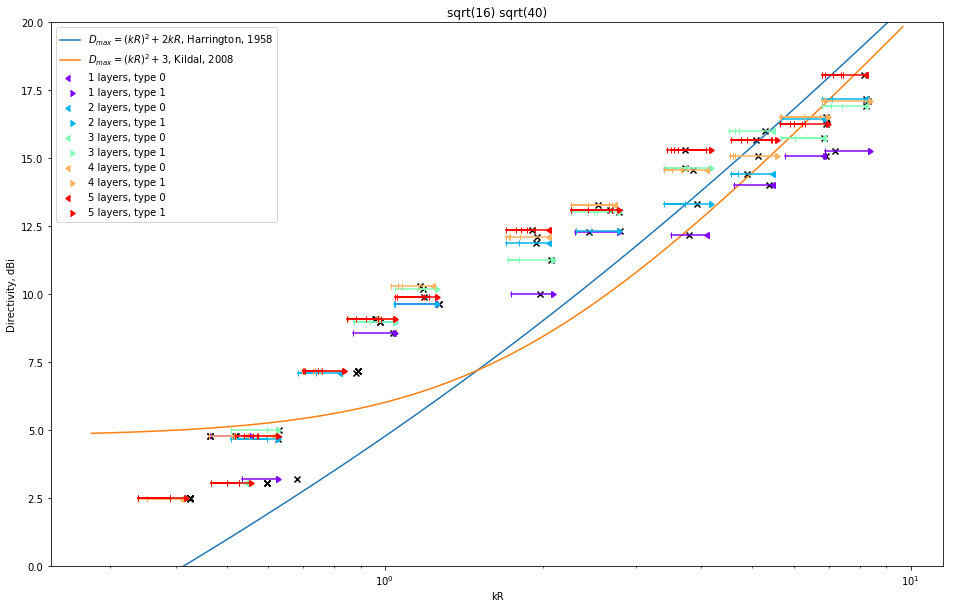

In [16]:
plot_data(data16_40, title='sqrt(16) sqrt(40)')

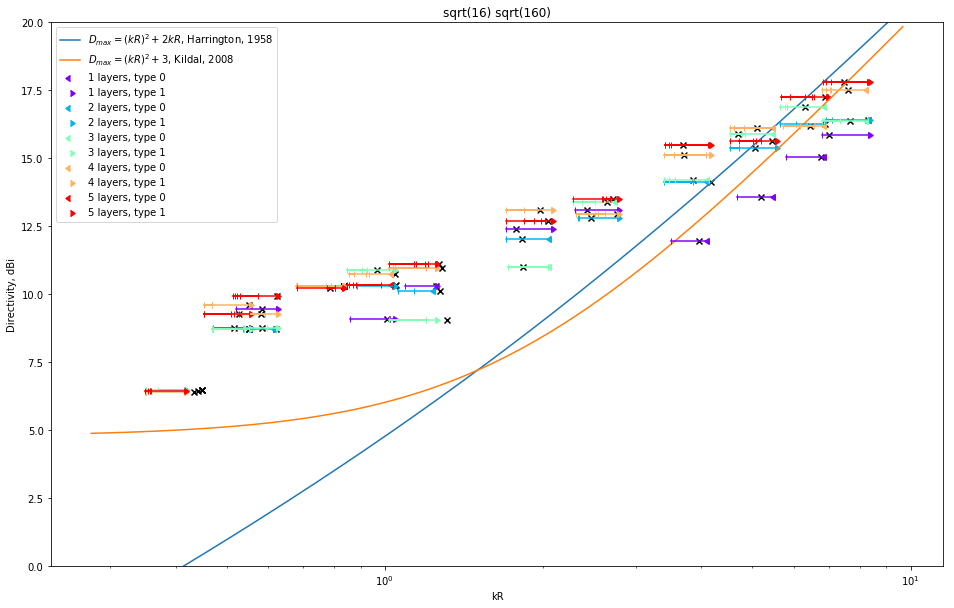

In [17]:
plot_data(data16_160, title='sqrt(16) sqrt(160)')

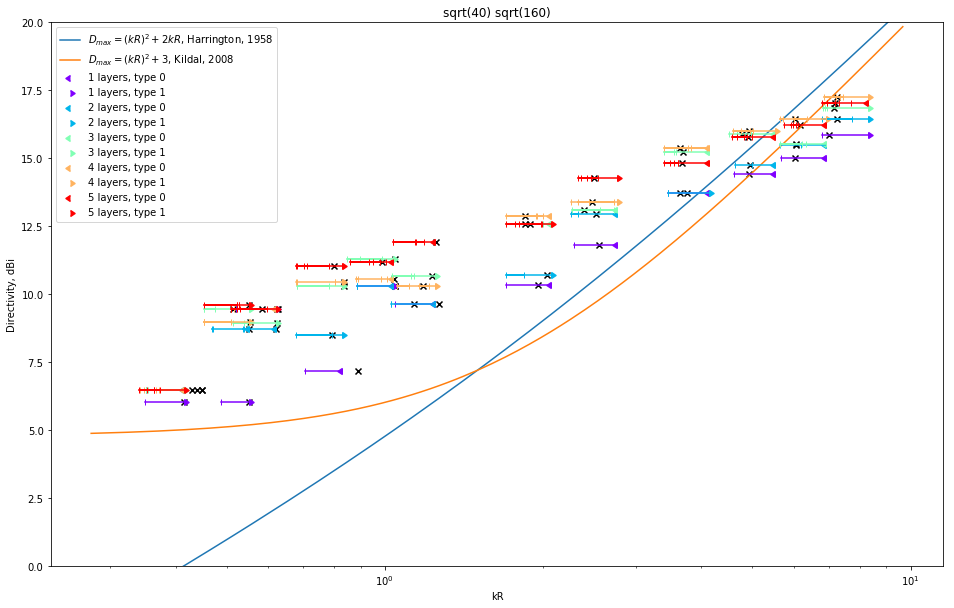

In [18]:
plot_data(data40_160, title='sqrt(40) sqrt(160)')